[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/9_nb_feature_engineering.ipynb) 

# Chapter 9 - Feature engineering and selection

Add links to
- https://machinelearningmastery.com/power-transforms-with-scikit-learn/
- https://machinelearningmastery.com/machine-learning-data-transforms-for-time-series-forecasting/

somewhere, where some nice demos are to be found.




Here is the outline of the tutorial:
- Preliminaries
- Feature engineering
- Feature selection
- Exercises

# Preliminaries
Basically as usual

I noted that in several places of the notebook, we will obtain a data set (e.g., after applying a feature transformation) and then want to estimate the performance (AUC) of a model trained and tested on that data. Here, it would be useful to write a helper function that does that, e.g., as a separate .py file, and import that function. This will also demonstrate how one can structure codes and that one does not have to put all code into the same notebook.  

- load standard libs
- load data
- Supply .py file with a helper function that
  - receives X, y and an sklearn classifier object as input
  - train-test-split the data
  - train classifier
  - return test set AUC
- Briefly explain what the helper is doing and demonstrate its use in the notebook
(this might be a place to demonstrate Python approach to pass arbitrary arguments to a function, which are then forwarded to other functions. Eg the helper could accept further arguments which are forwarded to eg train_test_split to eg allow setting the ratio of train/test data. Think about it and give it a try or abandon the idea if you feel it does not really make sense) 

# Feature Engineering

## Basic transformations revisited

We have discussed basic transformations in Tutorial 4 but never demonstrated the scaler class (or have we?). So we could start with a brief demo of how to do min/max scaling or standardization using the scaler class.

*Nice addition* there is a way in which you can code preparation chains: e.g., first replace all missing values, then standardize all numeric features, than one-hot-encode all categories. Here is an example https://www.kdnuggets.com/2019/12/build-pipelines-pandas-pdpipe.html of such **pipelines**. Either have a demo or simple add the before link for further studies. 

## Motivating example revisited
replicate motivating example from p8 of the slides or, similarly, here: https://www.kdnuggets.com/2018/12/feature-engineering-explained.html

## Common feature transformations for numeric data
- log, Box-Cox, Yeo-Johnson (see, e.g., p.11 of the slides)
  - give equation
  - implement as custom function
  - demonstrate by showing histograms of a feature before/after the transformation
- Which data to use? 
  - Can use an artificially generated feature with left/right skew
  - Can use one feature from HMEQ
  - I guess synthetic feature is better, any thoughts?
  
## Testing transformations
The promise of the above power transformations is that they increase normality. Statisticians have developed ways to test whether a feature displays a normal distribution. A Python implementation for one such test is available in the `statsmodels` library. Let's use the function `normaltest()` to verify the merit of our transformations.

In [ ]:
# Compare normality of feautre before/after applying a power transformation


## Encoding nominal features using weight-of-evidence coding

The focus in this part is to revisit WOE coding. Below, I copy/pasted code from other notebooks that provide a from scratch implementation and an example using `scorecardpy()`. Both codes needs adjustment. We can use the feature JOB from HMEQ to illustrate WOE. Basically, the outline for this part of the notebook can be as follows:
- Briefly summarize the idea of WOE and give equations 
- Showcase frequency counts / bar char of feature JOB as opener
- present and describe from scratch implementation
  - if you find the time, you could rework the from scratch implementation such that it functions more like a standard scaler class
  - eg have methods `transform()` , `fit_transform()` etc.
  - Ideally, one would then want to have a class, but this might go too far
- apply from scratch implementation to JOB and calculate IV
- create two logit models, one with JOB dummy-encoding another with JOB WOE encoded and compare their results
  - run vanilla ML pipeline with train-test split and AUC evaluation 
  - use statsmodel logit to also show regression results
- brief conclusion, stress that WOE is even more useful when having high-cardinal categories


### WOE from scratch

In [17]:
def calc_iv(df, feature, target, pr=False):
    """ Function to compute information value and WOE.clean_value
    
    Output: 
    * iv: float,
    * data: pandas.DataFrame

    See following kaggle page for reference:
    https://www.kaggle.com/puremath86/iv-woe-starter-for-python

    """

    # Code is taged as inefficient, due to for loop.
    # Better implementation would use:
    # df[feature].value_counts()
    # df_clean.groupby([target, feature]).count()
    # and then reorganize the resulting data structure


    # List to collect counts per category level 
    lst=[]

    #df[feature] = df[feature].fillna("NULL")
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        # Note that the following code assumes the target to be zero-one encoded
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good 
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad 
    
    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data["Share"] = data["All"] / data["All"].sum()
    data["Bad rate"] = data["Bad"] / data["All"]
    data["Distribution Bad"] = data["Bad"] / data["Bad"].sum()
    data["Distribution Good"] = (data["All"]-data["Bad"]) / (data["All"].sum()-data["Bad"].sum())
    # Calculation of WoE
    # This approach is not robust since Good/Bad counts might be zero for some level
    data["WoE"] = np.log(data["Distribution Good"] / data["Distribution Bad"])
    # Correct for NaN values due to above issue; better approach is to apply 
    # correction and compute adjusted WoE.
    data["WoE adj"] = np.log( 
        ( 
            (data["All"]-data["Bad"] + 0.5) / (data["All"].sum()-data["Bad"].sum())
        ) / 
        (
            (data["Bad"] + 0.5) / data["Bad"].sum()
        )
    )
    # See, e.g., Moeyersoms J., Martens D. (2015). Including high-cardinality
    # attributes in predictive models a case study in churn prediction in the energy sector. 
    # Decision support systems -72 (2015), 72-81.)
    data.replace({"WoE": {np.inf: 0, -np.inf: 0}})

    # Compute IV
    data["IV"] = data["WoE"] * (data["Distribution Good"]-data["Distribution Bad"])

    data = data.sort_values(by=["Variable", "Value"], ascending=[True, True])
    data.index = range(len(data.index))
    iv = data["IV"].sum()

    if pr :
        print(data)
        print("IV = {:.4f}".format(iv))

    return iv, data 

var = "CLAGE_cat"
iv, woe_table = calc_iv(df_clean, feature = var, target="BAD", pr=True)

if iv < .02:
    print("The variable {} is not predictive.".format(var))
elif iv < .1:
    print("The variable {} is weakly predictive.".format(var))
elif iv < .3:
    print("The variable {} is moderately predictive.".format(var))
else :
    print("The variable {} is highly predictive.".format(var))

    Variable    Value   All  Good  Bad     Share  Bad rate  Distribution Bad  \
0  CLAGE_cat  group 0  1490  1067  423  0.250000  0.283893          0.355761   
1  CLAGE_cat  group 1  1645  1240  405  0.276007  0.246201          0.340622   
2  CLAGE_cat  group 2  1335  1134  201  0.223993  0.150562          0.169050   
3  CLAGE_cat  group 3  1490  1330  160  0.250000  0.107383          0.134567   

   Distribution Good       WoE   WoE adj        IV  
0           0.223643 -0.464209 -0.464922  0.061331  
1           0.259904 -0.270464 -0.271294  0.021832  
2           0.237686  0.340758  0.338715  0.023388  
3           0.278768  0.728317  0.725573  0.105024  
IV = 0.2116
The variable CLAGE_cat is moderately predictive.


Create a WoE Plot

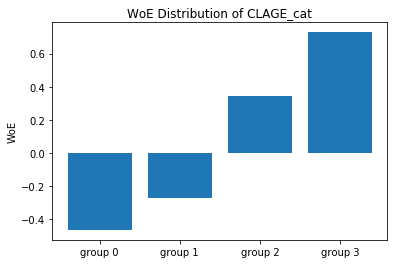

In [18]:
tmp=woe_table.sort_values("WoE", ascending=True)
plt.bar(tmp["Value"], tmp["WoE"])
plt.ylabel("WoE")
plt.title("WoE Distribution of {}".format(var))
plt.show()

### example using scorecardpy

[INFO] creating woe binning ...
Binning on 5960 rows and 2 columns in 00:00:22


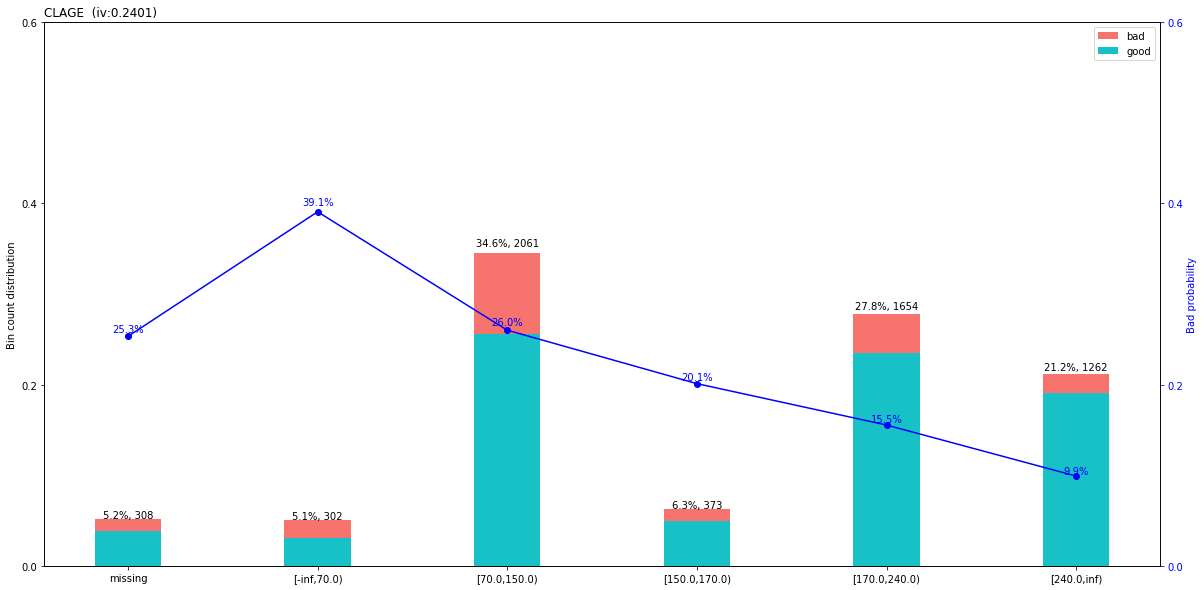

In [17]:
import scorecardpy as sc
temp = df[['CLAGE', 'BAD']] #select data to use, 'BAD' is needed to calculate the WOE
#todo edit variable 'CLAGE' to variable to use for WOE, no variable with high category count available

woe = sc.woebin(temp, y="BAD")
sc.woebin_plot(woe); #plotting the output

In [18]:
#df_woe = sc.woebin_ply(df, woe) 
# This would be the code to replace the original values of a variable with the WOE values. We will continue without using this variable.

# Feature Selection

## Filter methods
- p26 of the slides introduces filter methods:
  - correlation
  - Fisher score
  - $\chi^2$ and Cramer's V
  - Information gain
Write a custom class `my_filter` that allows computing the filter criteria. Well, the corresponding methods should then be static to not make the example too complicated. If you think class + static methods is an overkill, then simple have custom functions of the filters is also fine. We can then make coding the class an exercise. Demonstrate the functions using HMEQ. I guess different filters give different signals which features are most important. This can be discussed briefly. I guess it is fine to make use of the univariate scoring functions from sklearn, e.g., https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2

## Stepwise regression
Demonstrate vanilla stepwise logit using `statsmodels` and discuss the output. Does the order of variables / variable importance agree with what the filters predicts? Compare the stepwise logit model to a basic lasso logistic regression. Do the same features come out as important?

Mention that `sklearn` does not support stepwise regression (e.g., https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm) 

## Wrappers
Briefly discuss the functioning and then demonstrate `RFECV` (e.g., https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) as a powerful wrapper approach for feature selection. Apply it to HMEQ and compare the final feature set to that of logit. 

# Conclusions

The above demos should have provided some ideas, what transformation and selection strategies work well for HMEQ. As final experiment, perform a controlled comparison (same train/test data) of logit on the basic data set and a version to which high performing transformations and/or feature selection has been applied. Ideally we could show some performance improvement. If previous results suggest that this will not be the case for HMEQ, then maybe just skip the conclusion part and make this analysis an exercise. 

# Exercises

## Power transformations 
- Box-Cox (BC) and Yeo-Johnson (YJ) transformation exhibit hyperparameter $\lambda$. Implement a custom function that receives a feature as input and grid-searches the best value of $\lambda$. The caller should be able to specify whether s/he wants to use BC or YJ. Your function can assess the merit of a value of $\lambda$ by means of the function `normaltest()`, the use of which we illustrated above. The more normal a feature after the transformation, the better the value of $\lambda$. 

- Write another custom function `best_transform()`. Given a DataFrame with input data, your function should identify the best power transformation for each numerical feature. Note that using the raw feature without transformation is also possible and might be the best approach. Also remember to tune $\lambda$ when needed using your solution to the previous exercise. Try out your function using the HMEQ data. Display the best transformation for each feature.

**Optional** 
- Till here, we have assessed the merit of a transformation by means of checking normality using `normaltest()`. Arguably, a better approach for predictive modeling would be to test if a model trained on the transformed data generates better predictions. To implement this logic, you need a custom function that implements our standard predictive modeling pipeline (see, e.g., Tutorial 5 or Tutorial 7) to estimates the predictive performance of a model, say logistic regression, on an input data set. Once you have this function, you can revise your solutions to the previous exercises such that they call the function just implemented instead of `normaltest()`. 
- Test your function using the HMEQ data set
- Perform a final test what approach gives better results (in terms of AUC on HMEQ) optimizing feature transformations using `normaltest()` or by assessing predictive accuracy. *For the experts, make sure to not overfit* 
---
## Weight of evidence coding (challenging)
A standard risk modeling workflow in banking is the following
- Discretize all numeric features in a data set
- Optimize categorical features by re-grouping/merging category levels
- WOE transform all categorical variables
- Build logistic regression-based scorecard

Your task is to implement this workflow. The previous demos provide much of the functionality that you need. However, some extensions are needed and you have to put everything together. To keep things manageable, let's agree on the following heuristic:
Implement step 1 and step 2 by fitting a shallow tree to the data (e.g., at most 5 leaf nodes). This will work with numerical and categorical features alike. The leaf nodes of your shallow tree represent the new, re-grouped, optimized categorical features. After this tree-based transformation, you can WOE-encoded the whole data set in one go.

Compare a logit model using your transformed data set to one from our standard version of the data [add link here]

## Feature selection
- We discussed that sklearn does not offer stepwise regression. Implement a stepwise logit using AIC from scratch. To that end, you will need to decide on a search direction (forward or backward) and scoring criterion. The latter is needed for selecting the next feature to be added to or deleted from a model. Understanding the role of the search criterion is a very good learning outcome in its own right. There is probably no single correct or best solution how to score candidate features. Try to come up with a sensible approach.  